In [1]:
import numpy as np
from scipy.stats import ks_2samp
from scipy import stats
import matplotlib.pyplot as plt
import h5py
import time
import illustris_python_mod as il
import sys
import os
sys.path.append('../BH_dynamics_analysis')
sys.path.append('/home/pranavsatheesh/arepo_package/')
import arepo_package as arepo
from scipy.spatial import cKDTree
import BRAHMA_python as il_brahma
from tqdm import tqdm
import datetime
from scipy.spatial import cKDTree
from scipy.stats import ks_2samp

In [2]:
pop_file_path = '/home/pranavsatheesh/host_galaxies/data/population_files/' 
basePath="/orange/lblecha/aklantbhowmick/GAS_BASED_SEED_MODEL_UNIFORM_RUNS/L12p5n512/AREPO/output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_DFD_3/"

In [3]:
simName = basePath.split('/')[-2]

In [4]:
minNdm=0
minNgas=0
minNstar=100
minNbh=0

pop_file_name = pop_file_path+'brahma_pop_'+simName+'_gas-'+f'{minNgas:03d}'+'_dm-'+f'{minNdm:03d}'+'_star-'+f'{minNstar:03d}'+'_bh-'+f'{minNbh:03d}'+'.hdf5'

In [5]:
brahma_pop_Nstar100 = h5py.File(pop_file_name,'r')
print(brahma_pop_Nstar100.keys())

<KeysViewHDF5 ['merging_population', 'non_merging_population']>


In [6]:
minNstar=0
pop_file_name = pop_file_path+'brahma_pop_'+simName+'_gas-'+f'{minNgas:03d}'+'_dm-'+f'{minNdm:03d}'+'_star-'+f'{minNstar:03d}'+'_bh-'+f'{minNbh:03d}'+'.hdf5'
brahma_pop_Nstar0 = h5py.File(pop_file_name,'r')


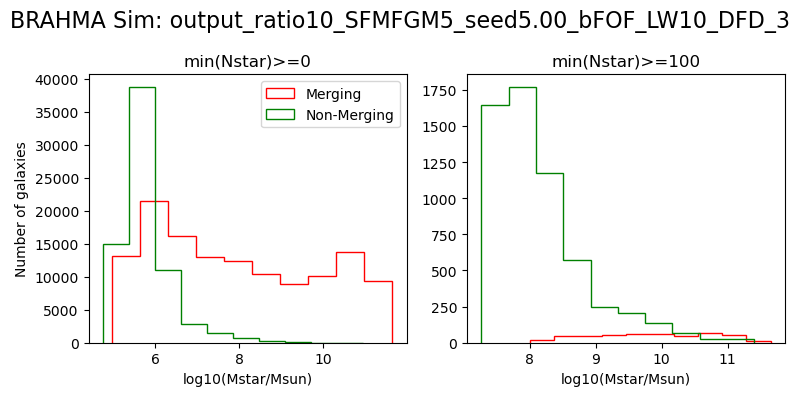

In [7]:
fig,axes = plt.subplots(1,2,figsize=[8,4])
axes[0].hist(np.log10(brahma_pop_Nstar0['merging_population']['Mstar'][brahma_pop_Nstar0['merging_population']['Mstar'][:]>0]),bins=10,histtype='step',color='red',label='Merging')
axes[0].hist(np.log10(brahma_pop_Nstar0['non_merging_population']['Mstar'][brahma_pop_Nstar0['non_merging_population']['Mstar'][:]>0]),bins=10,histtype='step',color='green',label='Non-Merging')
axes[0].set_xlabel('log10(Mstar/Msun)')
axes[0].set_ylabel('Number of galaxies')

axes[0].set_title('min(Nstar)>=0')
axes[1].set_title('min(Nstar)>=100')
axes[1].hist(np.log10(brahma_pop_Nstar100['merging_population']['Mstar'][brahma_pop_Nstar100['merging_population']['Mstar'][:]>0]),bins=10,histtype='step',color='red',label='Merging')
axes[1].hist(np.log10(brahma_pop_Nstar100['non_merging_population']['Mstar'][brahma_pop_Nstar100['non_merging_population']['Mstar'][:]>0]),bins=10,histtype='step',color='green',label='Non-Merging Nstar>100')
axes[0].legend(loc="upper right")
axes[1].set_xlabel('log10(Mstar/Msun)')

fig.suptitle('BRAHMA Sim: '+simName,fontsize=16)
fig.tight_layout()


In [8]:
pop_file_loc = "/home/pranavsatheesh/host_galaxies/data/population_files/new/"
#pop_file = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001_w_rsep_cut_1bh.hdf5"
pop_file_1000 = pop_file_loc + "population_sort_gas-000_dm-000_star-1000_bh-000_w_rsep_cut_1bh.hdf5"
# pop_file = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001_w_rsep_cut.hdf5"
pop_file_100 = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001_w_rsep_cut_1bh.hdf5"
#pop_100 = h5py.File(pop_file_100, 'r')
#pop_1000 = h5py.File(pop_file_1000, 'r')

#TNG50_pop_Nstar100 = h5py.File(pop_100,'r')
TNG50_pop_Nstar1000 = h5py.File(pop_file_100,'r')

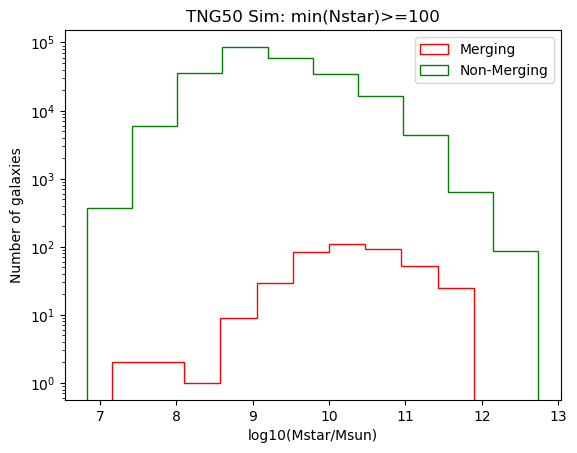

In [9]:
plt.hist(np.log10(TNG50_pop_Nstar1000['merging_population']['Mstar'][TNG50_pop_Nstar1000['merging_population']['Mstar'][:]>0]),bins=10,histtype='step',color='red',label='Merging')
plt.hist(np.log10(TNG50_pop_Nstar1000['non_merging_population']['Mstar'][TNG50_pop_Nstar1000['non_merging_population']['Mstar'][:]>0]),bins=10,histtype='step',color='green',label='Non-Merging')
plt.xlabel('log10(Mstar/Msun)')
plt.ylabel('Number of galaxies')
plt.yscale('log')
plt.xlabel('log10(Mstar/Msun)')
plt.title('TNG50 Sim: min(Nstar)>=100')
plt.legend(loc="upper right")
plt.show()

In [11]:
brahma_mergers_Mstar = brahma_pop_Nstar100['merging_population']['Mstar']
brahma_mergers_z = brahma_pop_Nstar100['merging_population']['z']

brahma_nonmergers_Mstar = brahma_pop_Nstar100['non_merging_population']['Mstar']
brahma_nonmergers_z = brahma_pop_Nstar100['non_merging_population']['z']

In [ ]:
merging_points = np.column_stack((merging_pop['z'],np.log10(merging_pop['Mstar'])))
non_merging_points = np.column_stack((non_merging_z,np.log10(non_merging_Mstar)))
tree = cKDTree(non_merging_points)
used = np.zeros(len(non_merging_points), dtype=bool)

control_indices = []

while True:
    closest_indices = np.full(len(merging_points), -1)
    
    tolerances = []
    for i in tqdm(range(len(merging_points)), desc="Processing merging points", ncols=100):
        #find the closest neibhour 
        dist, min_idx = tree.query(merging_points[i])
        if(used[min_idx]):
            dists,idxs = tree.query(merging_points[i],k=len(non_merging_points))
            min_idx = idxs[np.where(~used[idxs])[0][0]] 

        #check for tolerance:
        del_z = np.abs(merging_points[i][0]-non_merging_points[min_idx][0])
        dex_Mstar = np.abs(np.log10(merging_points[i][1]/non_merging_points[min_idx][1]))

        z_tolerance = 0.05
        Mstar_dex_tolerance = 0.1

        while True:
            if(del_z<z_tolerance and dex_Mstar<Mstar_dex_tolerance):
                used[min_idx] = True
                closest_indices[i] = min_idx
                tolerances.append((z_tolerance, Mstar_dex_tolerance))
                break
            else:
                closest_indices[i] = -1
                break

                

    control_indices.append(closest_indices)
        #D_mstar, p_Mstar = ks_2samp(pop['non_merging_population']['Mstar'][np.sort(closest_indices)],pop['merging_population']['Mstar'])
        #D_z, p_z = ks_2samp(pop['non_merging_population']['z'][np.sort(closest_indices)],pop['merging_population']['z'])
        
        #print(p_z,p_Mstar,np.shape(control_indices)[0])
        #print(z_tolerance,Mstar_dex_tolerance)

    if np.shape(control_indices)[0]>=1:
        break